### Working of this project

In [1]:
import cv2
import numpy as np
from sklearn.metrics import pairwise

### Step1 
: we have to set the ROI (region of interest)

In [2]:
# Global Variables
background = None

accumulated_weight = 0.5

roi_top=20
roi_bottom = 300
roi_right = 300
roi_left=600

In [3]:
def calc_accum_avg(frame,accumulated_weight):
    global background

    if background is None:
        background = frame.copy().astype('float')
        return None

    cv2.accumulateWeighted(frame,background,accumulated_weight)
    

### Step2:
once the hand enters the region then apply a threshold

In [7]:

def segmentation(frame,threshold=25):
    diff=cv2.absdiff(background.astype('uint8'),frame)
    ret,thresholded=cv2.threshold(diff,threshold,255,cv2.THRESH_BINARY)
    contours,hierarchy,=cv2.findContours(thresholded.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None

    else:
        hand_segments = max(contours,key=cv2.contourArea)

        return (thresholded,hand_segments)

### Step3:
Once the hand enters ROI then we use a Convex Hull to draw a polygon around the hand

### Convex Hull

A convex Hull draws a polygon by connecting points around the most external points in a frame


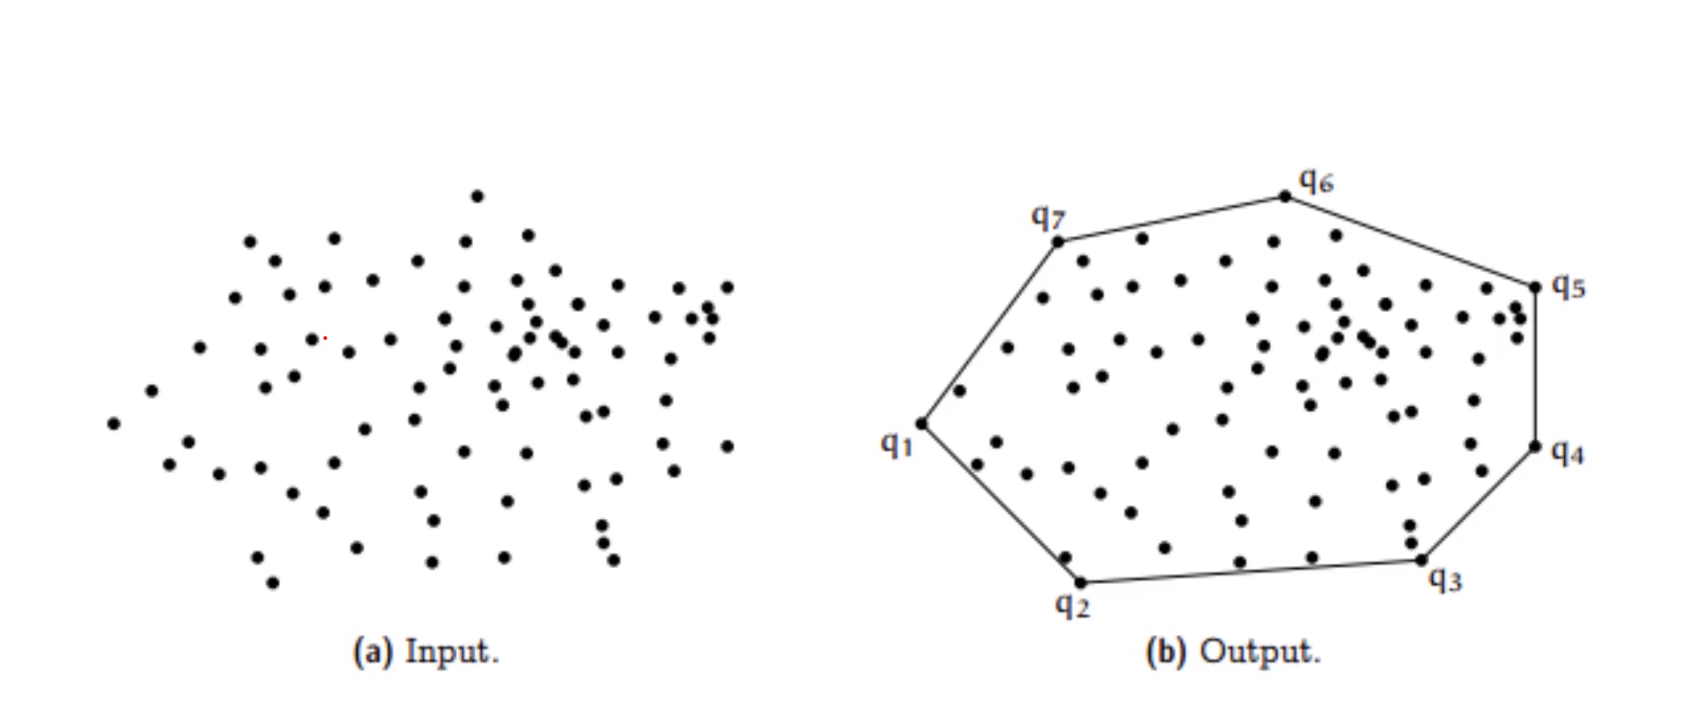

And this type of image is [assed to convex Hull 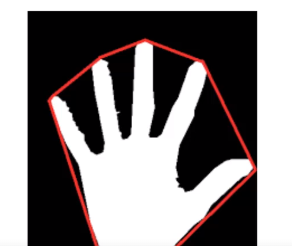


and when the output we get these points
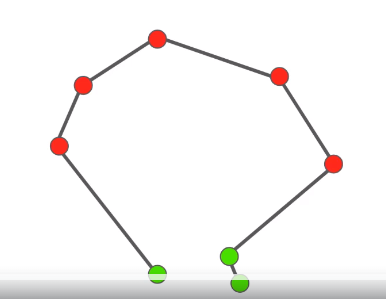

Now we calculate the most extreme points
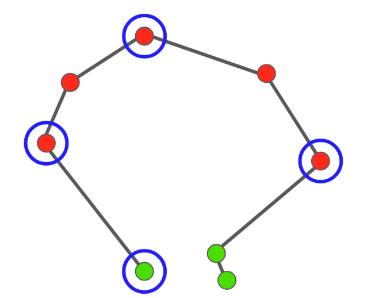

we we use these points to estimate the middle of the hand 
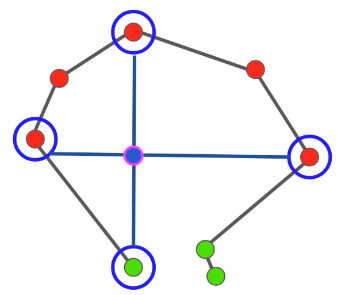

Now we calculate the distance further way from the middle of hand 
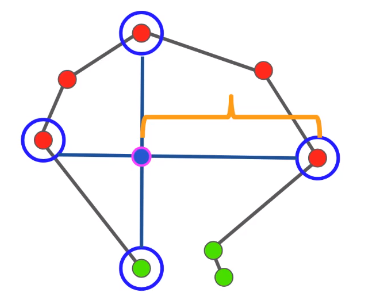

Using 90% of the distance we create a circle 
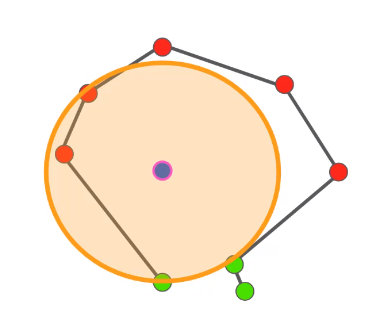

Now any points outside of this circle and far away from the bottom should be extended fingers 
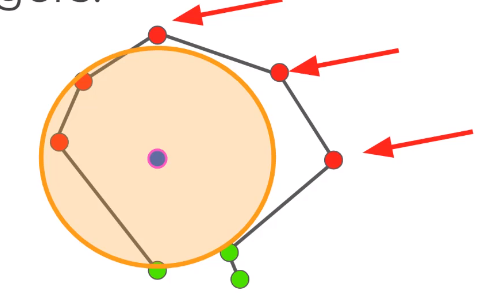

### Step4:
Using some Math we calculate the center of the hand against the angle of outer points to infer finger count

In [11]:
def count_fingers(thresholded,hand_segment):

    
    conv_hull=cv2.convexHull(hand_segment)


    
    #TOP POINT
    top = tuple(conv_hull[conv_hull[:,:,1].argmin()][0])
    bottom = tuple(conv_hull[conv_hull[:,:,1].argmax()][0])
    left = tuple(conv_hull[conv_hull[:,:,0].argmin()][0])
    right = tuple(conv_hull[conv_hull[:,:,0].argmax()][0])


    cX = (left[0] +right[0])//2
    cY = (top[1] + bottom[1])//2

    distance = pairwise.euclidean_distances([cX,cY],Y=[left,right,top,bottom])[0]

    max_distance = distance.max()

    radius  = int(0.9*max_distance)

    circumference = 2*np.pi*radius

    circular_roi = np.zeros(thresholded[:2],dtype='uint8')

    cv2.circle(circular_roi,(cX,cY),radius,255,10)

    circular = cv2.bitwise_and(thresholded,thresholded,mask=circular_roi)

    image,contours,hierarchy = cv2.findContours(circular_roi.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    count =0

    for cnt in contours:
        (x,y,w,h) = cv2.boundingRect(cnt)

        out_wrist = (cY + (Cy*0.25)) > (y+h)

        limit_points = ((circumference*0.25) > cnt.shape[0])

        if out_wrist and limit_points:
            count += 1

    return count

    




    

In [12]:
cam = cv2.VideoCapture(0)


num_frames  = 0


while True:

    ret ,frame  =cam.read()
    frame_copy = frame.copy()

    roi = frame[roi_top:roi_bottom,roi_right:roi_left]

    gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray,(7,7),0)

    if num_frames < 60:
        calc_accum_avg(gray,accumulated_weight)

        if num_frames <= 59:
            cv2.imshow('Finger Count',frame_copy)
    else:
        hand = segmentation(gray,25)

        if hand is not None:
            thresholded, hand_segment = hand
            #draws Contors on screen
            cv2.drawContours(frame_copy,[hand_segment+(roi_right,roi_top)],-1,(255,0,0),5)

            fingers = count_fingers(thresholded,hand_segment)
            cv2.putText(frame_copy,str("Count:"+fingers),(70,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)

            cv2.imshow('Thresholded',thresholded)
    cv2.rectangle(frame_copy,(roi_left,roi_top),(roi_right,roi_bottom),(0,0,255),5)

    num_frames +=1

    cv2.imshow('FingerCount',frame_copy)

    k = cv2.waitKey(1) & 0XFF

    if k ==27:
        break
cam.release()
cv2.destroyAllWindows()
    


        

ValueError: Expected 2D array, got 1D array instead:
array=[236. 271.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.